In [31]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.colors, matplotlib.cm as cm, os, sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable



In [30]:
def piston_model_matrix(rxy, rxyz, k, p0=8.02, d=10.5/1000):
    """
    Piston model calculator
    
        Finds the complex pressure propagated by transducers from one plane to another, 
        determined using the PM_pesb function. (see GS-PAT eq.2).
    
    Params:
        rxy = matrix describing Pythagorean distances between each transducer and each evaluation point in x and y
        rxyz = matrix describing Pythagorean distances between each transducer and each evaluation point in x, y and z.
        k = wavenumber
        p0 = (8.02 [Pa]) refernce pressure for Murata transducer measured at a distance of 1m
        d = (10.5/1000 [m]) spacing between Murata transducers in a lev board.
    """
    # 1st order Bessel function
    b = k*(d/2)*(rxy/rxyz)

    # taylor expansion of the bessel function
    tay = (1/2)-(b**2/16)+(b**4/384)-(b**6/18432)+(b**8/1474560)-(b**10/176947200)
    
    return 2*p0*(tay/rxyz)*np.exp(1j*k*rxyz)
    # return 2*(p0/b)*(tay/rxyz)*np.exp(1j*k*rxyz)

In [22]:
def pesb(side_length_x, side_length_y, dist, cell_spacing, tx, ty, tz):

    """pressure_evaluation_space_builder"""
    
    ex = np.arange(-side_length_x/2 + cell_spacing/2, 
                    side_length_x/2 + cell_spacing/2, 
                    cell_spacing ) # x side length vector 
    
    ey = np.arange(-side_length_y/2 + cell_spacing/2, 
                    side_length_y/2 + cell_spacing/2, 
                    cell_spacing) # y side length vector
    
    exx, eyy = np.meshgrid(ex, ey)
    print(exx)
    print(eyy)

    # x, y & z vectors for evaluation-plane sample points:
    px, py, pz = exx.flatten(), eyy.flatten(), dist*np.ones_like(exx.flatten())
    
    # Grids to describe the vector distances between each transducer & evaluation plane sample point.
    txv, pxv = np.meshgrid(tx,px)
    tyv, pyv = np.meshgrid(ty,py)
    tzv, pzv = np.meshgrid(tz,pz)
    
    rxyz = np.sqrt((txv-pxv)**2 + (tyv-pyv)**2 + (tzv-pzv)**2) # Pythagoras for xyz distances
    rxy = np.sqrt((txv-pxv)**2 + (tyv-pyv)**2) # Pythagoras for xy distances
    
    return rxyz, rxy


In [38]:
def transducer_grid( pitch, # inter-element spacing or pitch between adjacent transducer
                     transducers_m, 
                     transducers_n ):

    tx = np.arange(          # transducer arrangement in x 
        pitch * (-transducers_m + 1 ) /2, 
        pitch * ( transducers_m + 1 ) /2, 
        pitch ) 

    ty = np.arange(          # transducer arrangement in y 
        pitch * (-transducers_n + 1 ) /2, 
        pitch * ( transducers_n + 1 ) /2, 
        pitch ) 
    
    txx, tyy = np.meshgrid(tx, ty)
    tzz = np.zeros_like(txx)  # transducer arrangement in z
    
    print(txx)
    print(tyy)
    print(tzz)

    return txx, tyy, tzz


pitch, tm, tn = 10.5/1000, 2, 2 


transducer_grid( pitch, tm, tn )

[[-0.00525  0.00525]
 [-0.00525  0.00525]]
[[-0.00525 -0.00525]
 [ 0.00525  0.00525]]
[[0. 0.]
 [0. 0.]]


(array([[-0.00525,  0.00525],
        [-0.00525,  0.00525]]),
 array([[-0.00525, -0.00525],
        [ 0.00525,  0.00525]]),
 array([[0., 0.],
        [0., 0.]]))

In [36]:
def inlet_grid(  unit_cell_size,
                          side_length_x, 
                          side_length_y ):

    ex = np.arange(   # x side length vector 
        unit_cell_size * (-side_length_x + 1)/2, 
        unit_cell_size * ( side_length_x + 1)/2, 
        unit_cell_size ) 
    

    ey = np.arange(   # y side length vector
        unit_cell_size * (-side_length_y + 1)/2, 
        unit_cell_size * ( side_length_y + 1)/2, 
        unit_cell_size )
    

    exx, eyy = np.meshgrid(ex, ey)
    print(exx)
    print(eyy)

    # x, y & z vectors for evaluation-plane sample points:
    px, py = exx.flatten(), eyy.flatten()

    return px, py

c = 343 # m/s
v = 40000 # Hz
lam = c/v # m
m, n = 4, 4 # Metasurface size (in units of dx_AMM)

inlet_grid( lam/2, m, n )




[[-0.00643125 -0.00214375  0.00214375  0.00643125]
 [-0.00643125 -0.00214375  0.00214375  0.00643125]
 [-0.00643125 -0.00214375  0.00214375  0.00643125]
 [-0.00643125 -0.00214375  0.00214375  0.00643125]]
[[-0.00643125 -0.00643125 -0.00643125 -0.00643125]
 [-0.00214375 -0.00214375 -0.00214375 -0.00214375]
 [ 0.00214375  0.00214375  0.00214375  0.00214375]
 [ 0.00643125  0.00643125  0.00643125  0.00643125]]


(array([-0.00643125, -0.00214375,  0.00214375,  0.00643125, -0.00643125,
        -0.00214375,  0.00214375,  0.00643125, -0.00643125, -0.00214375,
         0.00214375,  0.00643125, -0.00643125, -0.00214375,  0.00214375,
         0.00643125]),
 array([-0.00643125, -0.00643125, -0.00643125, -0.00643125, -0.00214375,
        -0.00214375, -0.00214375, -0.00214375,  0.00214375,  0.00214375,
         0.00214375,  0.00214375,  0.00643125,  0.00643125,  0.00643125,
         0.00643125]))

[[-0.00643125 -0.00214375  0.00214375  0.00643125]
 [-0.00643125 -0.00214375  0.00214375  0.00643125]
 [-0.00643125 -0.00214375  0.00214375  0.00643125]
 [-0.00643125 -0.00214375  0.00214375  0.00643125]]
[[-0.00643125 -0.00643125 -0.00643125 -0.00643125]
 [-0.00214375 -0.00214375 -0.00214375 -0.00214375]
 [ 0.00214375  0.00214375  0.00214375  0.00214375]
 [ 0.00643125  0.00643125  0.00643125  0.00643125]]
H: (16, 16)
Pt: [1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
Pt shape:  (16,)
Pf: [[-498.03019692+255.53562578j -499.4244018 +294.76430226j
  -499.4244018 +294.76430226j -498.03019692+255.53562578j]
 [-499.4244018 +294.76430226j -498.49182466+335.42476067j
  -498.49182466+335.42476067j -499.4244018 +294.76430226j]
 [-499.4244018 +294.76430226j -498.49182466+335.42476067j
  -498.49182466+335.42476067j -499.4244018 +294.76430226j]
 [-498.03019692+255.53562578j -499.4244018 +294.76430226j
  -499.4244018 +294.76430226j

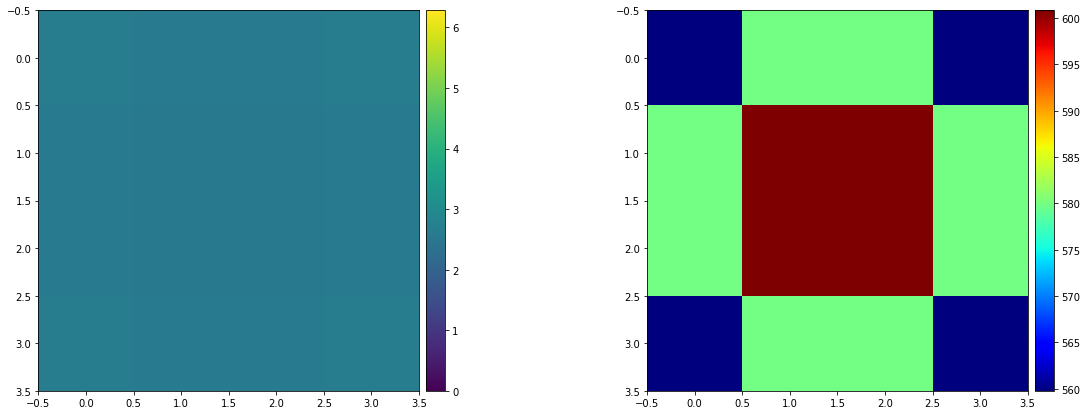

In [32]:
# ---> transducer params <---
c = 343                 # m/s
v = 40000               # Hz
lam = c/v               # m
k = 2*np.pi/lam         # rads/m
dx_tran = 10.5/1000     # diameter of a transducer [m] (actually they are 10mm in diameter, with a spacing of 0.5mm)
p0 = 8.02               # tranducer reference pressure [Pa] 
A = 1                   # amplitude for each transducer to take (max=1, min=0)

# ---> AMM params <---
dx_AMM = lam/2
prop_dist = 12*lam      # focal length of the AMM [m]
resolution = 10
iterations = 200


tran_m, tran_n = 4, 4   # Transducer configuration
dist = .2               # focal length of the board [m] and distance to the AMM
m, n = 4, 4             # Metasurface size (in units of dx_AMM)

x = np.arange(          # transducer arrangement in x 
    dx_tran * (-tran_m + 1 ) /2, 
    dx_tran * ( tran_m + 1 ) /2, 
    dx_tran ) 

y = np.arange(          # transducer arrangement in y 
    dx_tran * (-tran_n + 1 ) /2, 
    dx_tran * ( tran_n + 1 ) /2, 
    dx_tran ) 

tx, ty = np.meshgrid(x, y)

tz = np.zeros_like(tx)  # transducer arrangement in z

rxyz, rxy = pesb( m * lam/2, n * lam/2, 
                  dist, 
                  lam/2, 
                  tx, ty, tz )

H = piston_model_matrix( rxy, rxyz, k, p0, dx_tran ) # propagator

Pt = A * np.ones( tran_m * tran_n ) * np.exp( 1j * np.zeros( tran_m * tran_n ) ) # transducer complex pressure

Pf = np.dot( H, Pt ).reshape( m, n ) # propagate to far field and reshape to array


print("H:", H.shape)
print("Pt:", Pt)
print("Pt shape: ", Pt.shape)
print(f'Pf: {Pf}')
print(f'Pf shape: {Pf.shape}')

# Plotting
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

im1 = ax1.imshow(   np.mod( np.angle(Pf), 2*np.pi), 
                    cmap = cm.get_cmap('viridis'), 
                    vmin = 0, 
                    vmax = 2*np.pi ) # phase

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size='5%', pad=.1)
# ax1.title.set_text("phasemap")
# ax1.set_title("phasemap", fontsize=15)
plt.colorbar(im1, cax=cax1)

im2 = ax2.imshow(   abs(Pf), 
                    cmap=cm.get_cmap('jet') )

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size='5%', pad=.1)
# ax2.set_title("propagation", fontsize=15)
plt.colorbar(im2, cax=cax2)

# fig.tight_layout()
plt.show()